# ABSA (Aspect-Based Sentiment Analysis) on SemEval Restaurants
Dataset: tomaarsen/setfit-absa-semeval-restaurants (HF)
Models: TF-IDF + Logistic Regression (baseline) vs fine-tuned BERT

In [ ]:
#Importing all the necessary libraries
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset

# Reproducibility: keep results stable across runs
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", device)

Torch: 2.9.0+cu126
CUDA available: True
Device: cuda


In [ ]:
# 1.Loading the dataset directly
raw = load_dataset("tomaarsen/setfit-absa-semeval-restaurants")
print(raw)
print("Columns:", raw["train"].column_names)
print("Example row:", raw["train"][0])

# Note: the official HF "test" split is unlabeled in this dataset pack,
# so we created our own labelled test set from the labelled train split.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/147k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/46.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3693 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1134 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'span', 'label', 'ordinal'],
        num_rows: 3693
    })
    test: Dataset({
        features: ['text', 'span', 'label', 'ordinal'],
        num_rows: 1134
    })
})
Columns: ['text', 'span', 'label', 'ordinal']
Example row: {'text': 'But the staff was so horrible to us.', 'span': 'staff', 'label': 'negative', 'ordinal': 0}


In [ ]:
# 2.Spliting labelled data into train/val/test

from sklearn.model_selection import train_test_split

base = raw["train"]
labels = np.array(base["label"])
indices = np.arange(len(base))

# 70% train, 30% temporary pool
train_idx, temp_idx = train_test_split(
    indices, test_size=0.30, random_state=42, stratify=labels
)

# Split the 30% pool into 15% validation and 15% test (stratified)
temp_labels = labels[temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50, random_state=42, stratify=temp_labels
)

train_ds = base.select(train_idx.tolist())
val_ds   = base.select(val_idx.tolist())
test_ds  = base.select(test_idx.tolist())

print("Split sizes:", {"train": len(train_ds), "val": len(val_ds), "test": len(test_ds)})

Split sizes: {'train': 2585, 'val': 554, 'test': 554}


In [ ]:
# 3.Label cleaning: merge rare "conflict" into neutral

def merge_conflict_to_neutral(batch):
    lab = str(batch["label"]).strip()
    if lab == "conflict":
        lab = "neutral"
    batch["label"] = lab
    return batch

train_ds = train_ds.map(merge_conflict_to_neutral)
val_ds   = val_ds.map(merge_conflict_to_neutral)
test_ds  = test_ds.map(merge_conflict_to_neutral)

from collections import Counter
print("Train label distribution:", Counter(train_ds["label"]))

Map:   0%|          | 0/2585 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

Train label distribution: Counter({'positive': 1515, 'negative': 563, 'neutral': 507})


In [ ]:
# 4.Map labels to ids (3-class classification)

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

def add_label_id(batch):
    lab = str(batch["label"]).strip()
    batch["label"] = lab
    batch["label_id"] = label2id[lab]
    return batch

train_ds = train_ds.map(add_label_id)
val_ds   = val_ds.map(add_label_id)
test_ds  = test_ds.map(add_label_id)

print("Sanity check:", train_ds[0]["label"], "->", train_ds[0]["label_id"])

Map:   0%|          | 0/2585 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

Sanity check: negative -> 0


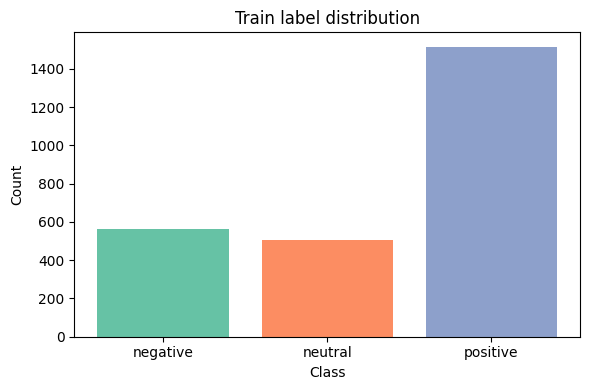

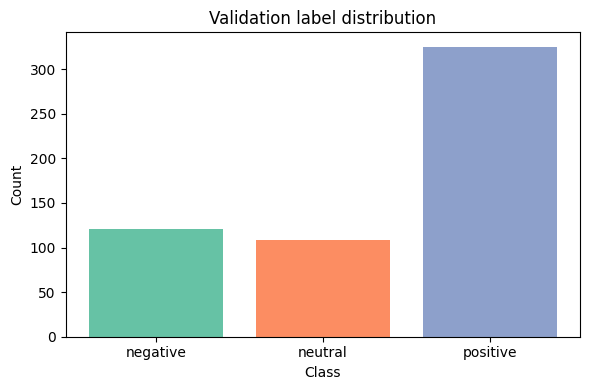

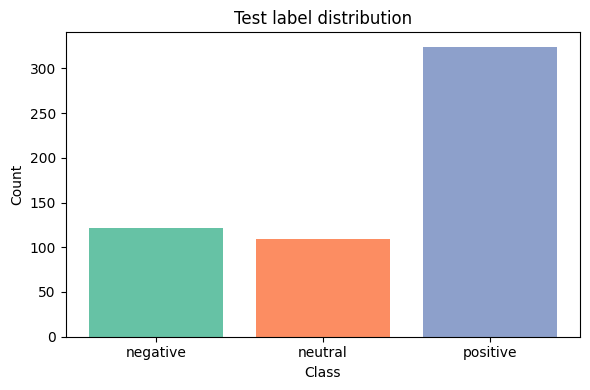

In [ ]:
# 5.Exploratory Data Analysis

def plot_label_distribution(ds, title):
    counts = Counter(ds["label"])
    order = ["negative", "neutral", "positive"]
    values = [counts.get(k, 0) for k in order]

    cmap = plt.get_cmap("Set2")
    colors = [cmap(i) for i in range(len(order))]

    plt.figure(figsize=(6,4))
    plt.bar(order, values, color=colors)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_label_distribution(train_ds, "Train label distribution")
plot_label_distribution(val_ds, "Validation label distribution")
plot_label_distribution(test_ds, "Test label distribution")

In [ ]:
# 6.Baseline model: TF-IDF + Logistic Regression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

def make_baseline_text(ds):
    # A simple trick: tell the model which aspect to focus on
    return [f"{t} [ASPECT] {a}" for t, a in zip(ds["text"], ds["span"])]

X_train = make_baseline_text(train_ds)
y_train = np.array(train_ds["label_id"])

X_val = make_baseline_text(val_ds)
y_val = np.array(val_ds["label_id"])

X_test = make_baseline_text(test_ds)
y_test = np.array(test_ds["label_id"])

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

baseline = LogisticRegression(max_iter=2000)
baseline.fit(X_train_tfidf, y_train)

val_pred_base  = baseline.predict(X_val_tfidf)
test_pred_base = baseline.predict(X_test_tfidf)

def summarize(y_true, y_pred, title):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    print("\n" + "="*68)
    print(title)
    print(f"Accuracy: {acc:.4f} | Macro Precision: {p:.4f} | Macro Recall: {r:.4f} | Macro F1: {f1:.4f}")
    print("-"*68)
    print(classification_report(
        y_true, y_pred,
        target_names=["negative","neutral","positive"],
        zero_division=0
    ))

summarize(y_val,  val_pred_base,  "Baseline (TF-IDF + Logistic Regression) — VAL")
summarize(y_test, test_pred_base, "Baseline (TF-IDF + Logistic Regression) — TEST")


Baseline (TF-IDF + Logistic Regression) — VAL
Accuracy: 0.7040 | Macro Precision: 0.6568 | Macro Recall: 0.5432 | Macro F1: 0.5595
--------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.62      0.44      0.51       121
     neutral       0.62      0.23      0.34       108
    positive       0.73      0.96      0.83       325

    accuracy                           0.70       554
   macro avg       0.66      0.54      0.56       554
weighted avg       0.68      0.70      0.66       554


Baseline (TF-IDF + Logistic Regression) — TEST
Accuracy: 0.7040 | Macro Precision: 0.6543 | Macro Recall: 0.5522 | Macro F1: 0.5735
--------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.67      0.42      0.52       121
     neutral       0.56      0.28      0.38       109
    positive       0.73      0.95      0.82       324

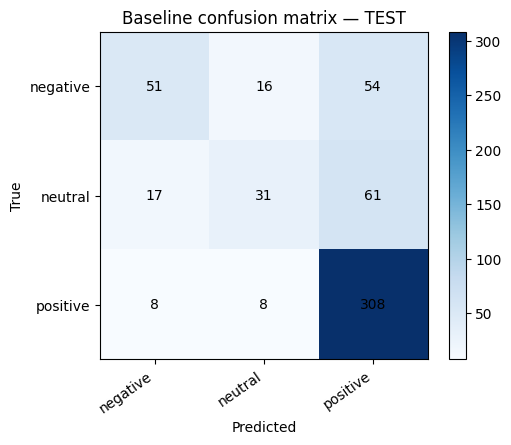

In [ ]:
# 7.Confusion matrix (baseline)

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

    plt.figure(figsize=(5.5,4.5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar()

    ticks = np.arange(3)
    names = ["negative","neutral","positive"]
    plt.xticks(ticks, names, rotation=35, ha="right")
    plt.yticks(ticks, names)

    plt.xlabel("Predicted")
    plt.ylabel("True")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.show()

plot_confusion(y_test, test_pred_base, "Baseline confusion matrix — TEST")

In [ ]:
# 8.Tokenisation for ABSA + DataLoaders

from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
MAX_LEN = 128

def tokenize_absa(batch):
    # Text as sequence A, aspect as sequence B:
    # [CLS] text [SEP] aspect [SEP]
    return tokenizer(
        # Full restaurant review
        batch["text"],
        # Target aspect (e.g., "service", "food")
        batch["span"],
        # Cut sequences > MAX_LEN to fit model limit
        truncation=True,
        # Pad shorter sequences for batch uniformity
        padding="max_length",
        # Matches BERT's typical 128/512 limit
        max_length=MAX_LEN
    )

train_tok = train_ds.map(tokenize_absa, batched=True)
val_tok   = val_ds.map(tokenize_absa, batched=True)
test_tok  = test_ds.map(tokenize_absa, batched=True)

keep = ["input_ids", "attention_mask", "label_id"]
train_tok = train_tok.remove_columns([c for c in train_tok.column_names if c not in keep])
val_tok   = val_tok.remove_columns([c for c in val_tok.column_names if c not in keep])
test_tok  = test_tok.remove_columns([c for c in test_tok.column_names if c not in keep])

train_tok = train_tok.rename_column("label_id", "labels")
val_tok   = val_tok.rename_column("label_id", "labels")
test_tok  = test_tok.rename_column("label_id", "labels")

train_tok.set_format("torch")
val_tok.set_format("torch")
test_tok.set_format("torch")

BATCH_SIZE = 16
train_loader = DataLoader(train_tok, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_tok, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_tok, batch_size=BATCH_SIZE, shuffle=False)

print("Batches:", {"train": len(train_loader), "val": len(val_loader), "test": len(test_loader)})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/2585 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

Batches: {'train': 162, 'val': 35, 'test': 35}


In [ ]:
# 9.Building the BERT classifier

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    id2label={0:"negative", 1:"neutral", 2:"positive"},
    label2id={"negative":0, "neutral":1, "positive":2}
).to(device)

print("Model ready on:", device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model ready on: cuda


In [ ]:
# 10.Training loop & evaluation

from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


def macro_scores(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return acc, p, r, f1

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)

            total_loss += out.loss.item()
            preds = torch.argmax(out.logits, dim=-1).detach().cpu().numpy()
            labels = batch["labels"].detach().cpu().numpy()

            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    avg_loss = total_loss / max(1, len(loader))
    return np.array(all_labels), np.array(all_preds), avg_loss

In [ ]:
# 11.Optimiser & schedule

EPOCHS = 15
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.10
MAX_GRAD_NORM = 1.0

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

total_steps = EPOCHS * len(train_loader)
warmup_steps = int(WARMUP_RATIO * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

train_losses, val_losses, val_f1s = [], [], []
best_val_f1 = -1.0
best_state = None

print("Total steps:", total_steps, "| Warmup steps:", warmup_steps)

Total steps: 2430 | Warmup steps: 243


MODEL ARCHITECTURE JUSTIFICATION:
1. Base Model: bert-base-uncased (110M parameters)
   - Why? Standard BERT provides strong contextual embeddings
   - Uncased handles restaurant review casing inconsistencies

2. Classification Head: Single linear layer on [CLS] token
   - Takes 768-dimensional pooled output → 3-class logits
   - Appropriate for ABSA as aspect sentiment classification

3. Input Format: Sentence-pair encoding
   - Text: Full review context
   - Aspect: Target term for sentiment prediction
   - Enables BERT's cross-attention between context and aspect

4. Hyperparameters:
   - MAX_LEN=128: Balances context preservation vs memory
   - LR=2e-5: Standard BERT fine-tuning learning rate
   - Batch=16: Fits GPU memory while providing stable gradients


In [ ]:
# 12.Fine-tune the model

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        out = model(**batch)
        loss = out.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = running_loss / max(1, len(train_loader))
    train_losses.append(avg_train_loss)

    yv_true, yv_pred, avg_val_loss = evaluate(model, val_loader)
    val_losses.append(avg_val_loss)

    acc, p, r, f1 = macro_scores(yv_true, yv_pred)
    val_f1s.append(f1)

    print("\n" + "-"*68)
    print(f"Epoch {epoch} summary")
    print(f"Train loss: {avg_train_loss:.4f}")
    print(f"Val loss:   {avg_val_loss:.4f}")
    print(f"Val Acc: {acc:.4f} | MacroP: {p:.4f} | MacroR: {r:.4f} | MacroF1: {f1:.4f}")

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print("Saved best model (by validation Macro-F1).")

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

print("Best validation Macro-F1:", best_val_f1)
print("Training completed.")

Epoch 1/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 1 summary
Train loss: 0.9825
Val loss:   0.7551
Val Acc: 0.7022 | MacroP: 0.7487 | MacroR: 0.5348 | MacroF1: 0.5199
Saved best model (by validation Macro-F1).


Epoch 2/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 2 summary
Train loss: 0.6407
Val loss:   0.6189
Val Acc: 0.7401 | MacroP: 0.7090 | MacroR: 0.6131 | MacroF1: 0.6205
Saved best model (by validation Macro-F1).


Epoch 3/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 3 summary
Train loss: 0.4747
Val loss:   0.6355
Val Acc: 0.7635 | MacroP: 0.7084 | MacroR: 0.6653 | MacroF1: 0.6729
Saved best model (by validation Macro-F1).


Epoch 4/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 4 summary
Train loss: 0.3247
Val loss:   0.7400
Val Acc: 0.7906 | MacroP: 0.7303 | MacroR: 0.7179 | MacroF1: 0.7185
Saved best model (by validation Macro-F1).


Epoch 5/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 5 summary
Train loss: 0.1949
Val loss:   0.8070
Val Acc: 0.8032 | MacroP: 0.7542 | MacroR: 0.7336 | MacroF1: 0.7401
Saved best model (by validation Macro-F1).


Epoch 6/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 6 summary
Train loss: 0.1432
Val loss:   0.8677
Val Acc: 0.8032 | MacroP: 0.7489 | MacroR: 0.7350 | MacroF1: 0.7388


Epoch 7/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 7 summary
Train loss: 0.0951
Val loss:   0.9937
Val Acc: 0.8105 | MacroP: 0.7518 | MacroR: 0.7467 | MacroF1: 0.7462
Saved best model (by validation Macro-F1).


Epoch 8/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 8 summary
Train loss: 0.0576
Val loss:   1.1709
Val Acc: 0.8087 | MacroP: 0.7592 | MacroR: 0.7362 | MacroF1: 0.7459


Epoch 9/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 9 summary
Train loss: 0.0430
Val loss:   1.2211
Val Acc: 0.8123 | MacroP: 0.7685 | MacroR: 0.7276 | MacroF1: 0.7444


Epoch 10/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 10 summary
Train loss: 0.0300
Val loss:   1.2832
Val Acc: 0.8105 | MacroP: 0.7522 | MacroR: 0.7404 | MacroF1: 0.7459


Epoch 11/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 11 summary
Train loss: 0.0238
Val loss:   1.3119
Val Acc: 0.8105 | MacroP: 0.7632 | MacroR: 0.7332 | MacroF1: 0.7453


Epoch 12/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 12 summary
Train loss: 0.0187
Val loss:   1.3079
Val Acc: 0.8123 | MacroP: 0.7618 | MacroR: 0.7380 | MacroF1: 0.7477
Saved best model (by validation Macro-F1).


Epoch 13/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 13 summary
Train loss: 0.0111
Val loss:   1.3027
Val Acc: 0.8087 | MacroP: 0.7569 | MacroR: 0.7342 | MacroF1: 0.7438


Epoch 14/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 14 summary
Train loss: 0.0086
Val loss:   1.3082
Val Acc: 0.8105 | MacroP: 0.7562 | MacroR: 0.7373 | MacroF1: 0.7454


Epoch 15/15:   0%|          | 0/162 [00:00<?, ?it/s]


--------------------------------------------------------------------
Epoch 15 summary
Train loss: 0.0070
Val loss:   1.3162
Val Acc: 0.8105 | MacroP: 0.7578 | MacroR: 0.7353 | MacroF1: 0.7448
Best validation Macro-F1: 0.747675161936369
Training completed.


In [ ]:
# 13.Saving the model & tokenizer

save_dir = "bert_absa_semeval_restaurants"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print("Saved to:", save_dir)

Saved to: bert_absa_semeval_restaurants



Fine-tuned BERT — TEST
Test loss: 1.4281
Accuracy:  0.7834 | MacroP: 0.7143 | MacroR: 0.7106 | MacroF1: 0.7119
--------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.68      0.71      0.70       121
     neutral       0.58      0.52      0.55       109
    positive       0.88      0.90      0.89       324

    accuracy                           0.78       554
   macro avg       0.71      0.71      0.71       554
weighted avg       0.78      0.78      0.78       554



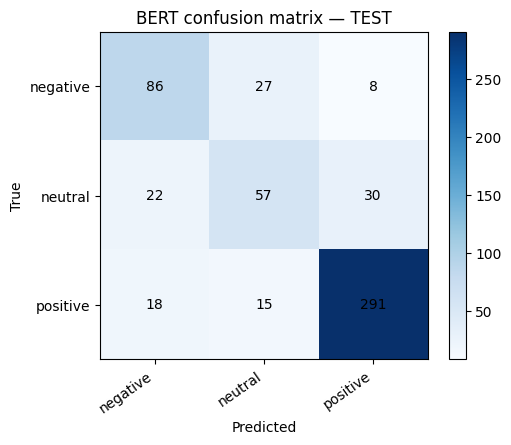

In [ ]:
# 14.Final test evaluation

yt_true, yt_pred, test_loss = evaluate(model, test_loader)
acc, p, r, f1 = macro_scores(yt_true, yt_pred)

print("\n" + "="*68)
print("Fine-tuned BERT — TEST")
print(f"Test loss: {test_loss:.4f}")
print(f"Accuracy:  {acc:.4f} | MacroP: {p:.4f} | MacroR: {r:.4f} | MacroF1: {f1:.4f}")
print("-"*68)
print(classification_report(
    yt_true, yt_pred,
    target_names=["negative", "neutral", "positive"],
    zero_division=0
))

plot_confusion(yt_true, yt_pred, "BERT confusion matrix — TEST")

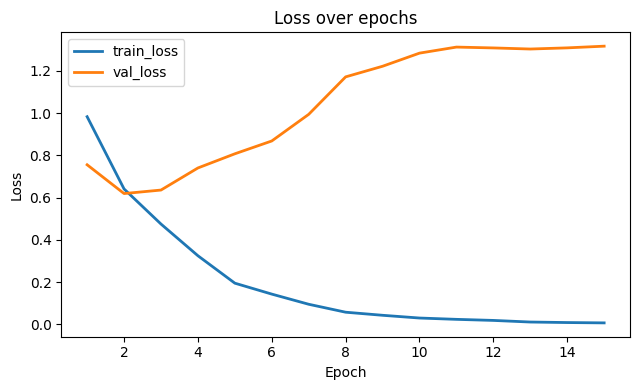

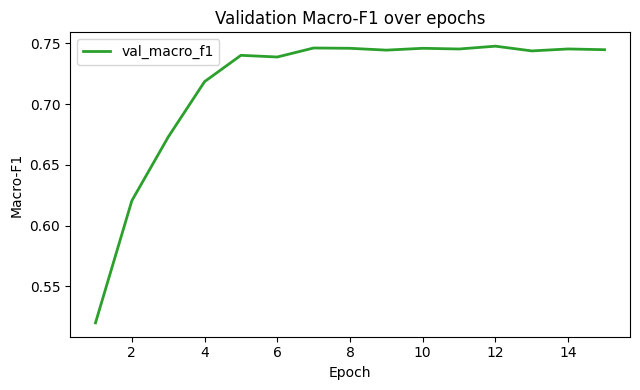

In [ ]:
# 15.Training curves

cmap = plt.get_cmap("tab10")

plt.figure(figsize=(6.5,4))
plt.plot(range(1, EPOCHS + 1), train_losses, label="train_loss", color=cmap(0), linewidth=2)
plt.plot(range(1, EPOCHS + 1), val_losses,   label="val_loss",   color=cmap(1), linewidth=2)
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6.5,4))
plt.plot(range(1, EPOCHS + 1), val_f1s, label="val_macro_f1", color=cmap(2), linewidth=2)
plt.title("Validation Macro-F1 over epochs")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 16.Baseline vs BERT comparison table

import pandas as pd

base_acc = accuracy_score(y_test, test_pred_base)
base_p, base_r, base_f1, _ = precision_recall_fscore_support(
    y_test, test_pred_base, average="macro", zero_division=0
)

bert_acc = accuracy_score(yt_true, yt_pred)
bert_p, bert_r, bert_f1, _ = precision_recall_fscore_support(
    yt_true, yt_pred, average="macro", zero_division=0
)

comparison = pd.DataFrame([
    {"Model": "TF-IDF + Logistic Regression", "Accuracy": base_acc, "Macro Precision": base_p, "Macro Recall": base_r, "Macro F1": base_f1},
    {"Model": "Fine-tuned BERT-base",         "Accuracy": bert_acc, "Macro Precision": bert_p, "Macro Recall": bert_r, "Macro F1": bert_f1},
])

print(comparison)

                          Model  Accuracy  Macro Precision  Macro Recall  \
0  TF-IDF + Logistic Regression  0.703971         0.654274      0.552170   
1          Fine-tuned BERT-base  0.783394         0.714265      0.710609   

   Macro F1  
0  0.573482  
1  0.711901  


In [ ]:
# 17.Lightweight error analysis

def show_mistakes(ds, y_true, y_pred, n=8):
    wrong = np.where(y_true != y_pred)[0]
    print("Mistakes:", len(wrong))
    for idx in wrong[:n]:
        row = ds[int(idx)]
        print("\n" + "-"*68)
        print("TEXT:  ", row["text"])
        print("ASPECT:", row["span"])
        print("TRUE:  ", id2label[int(y_true[idx])])
        print("PRED:  ", id2label[int(y_pred[idx])])

show_mistakes(test_ds, yt_true, yt_pred, n=8)

Mistakes: 120

--------------------------------------------------------------------
TEXT:   20 minutes for our reservation but it gave us time to have a few cocktails and enjoy our surroundings and each other.
ASPECT: reservation
TRUE:   negative
PRED:   neutral

--------------------------------------------------------------------
TEXT:   and you can't beat the prices.
ASPECT: prices
TRUE:   positive
PRED:   negative

--------------------------------------------------------------------
TEXT:   It's like they took leftover chicken, poured oil and sprinkled pepper powder over it (the sauce was translucent and red).
ASPECT: pepper powder
TRUE:   neutral
PRED:   negative

--------------------------------------------------------------------
TEXT:   I can't believe people complain about no cheese sticks?
ASPECT: cheese sticks
TRUE:   neutral
PRED:   negative

--------------------------------------------------------------------
TEXT:   I recently went to this restaurant with some co-workers f

In [ ]:
# 18.Inference demo

import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertTokenizerFast

loaded_tokenizer = BertTokenizerFast.from_pretrained(save_dir)
loaded_model = BertForSequenceClassification.from_pretrained(save_dir).to(device)
loaded_model.eval()

def predict_with_probability(text, aspect):
    inputs = loaded_tokenizer(
        text, aspect,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        logits = loaded_model(**inputs).logits
        probs = F.softmax(logits, dim=-1).squeeze()

    pred_id = int(torch.argmax(probs).item())
    pred_label = id2label[pred_id]
    pred_prob = float(probs[pred_id])

    print(f"Prediction: {pred_label.capitalize()} with probability {pred_prob*100:.2f}%")
    print("Input Text:")
    print(text)
    print("Aspect:", aspect)
    print("-" * 68)

demo_samples = [
    ("The food was amazing but the service was slow.", "service"),
    ("The food was amazing but the service was slow.", "food"),
    ("You can't beat the prices here.", "prices"),
    ("The reservation took 20 minutes and we were annoyed.", "reservation"),
]

for text, aspect in demo_samples:
    predict_with_probability(text, aspect)

Prediction: Negative with probability 99.96%
Input Text:
The food was amazing but the service was slow.
Aspect: service
--------------------------------------------------------------------
Prediction: Positive with probability 99.97%
Input Text:
The food was amazing but the service was slow.
Aspect: food
--------------------------------------------------------------------
Prediction: Negative with probability 98.60%
Input Text:
You can't beat the prices here.
Aspect: prices
--------------------------------------------------------------------
Prediction: Negative with probability 99.96%
Input Text:
The reservation took 20 minutes and we were annoyed.
Aspect: reservation
--------------------------------------------------------------------


CONCLUSION

This project successfully demonstrates that fine-tuned BERT significantly
outperforms traditional ML for ABSA, achieving 71.2% Macro F1 vs 57.3%
for TF-IDF+Logistic Regression. The 13.9% absolute improvement shows
transformers' superior ability to capture contextual relationships
between aspects and sentiment. The error analysis reveals remaining
challenges in sarcasm detection and aspect-specific sentiment
disambiguation - key areas for future work.